In [1]:
import os 
#import wget
import urllib.request
import requests
import tarfile
import fileinput
from pysep import recsec
from pysep.recsec import plotw_rs,RecordSection
from obspy import read, Stream,read_events
from glob import glob
import pandas as pd
from pysep.utils.io import read_sem, read_sem_cartesian
from pysep.utils.io import read_specfem3d_cmtsolution_cartesian,read_stations
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
import numpy as np

In [2]:
url_dsm ='https://www.eri.u-tokyo.ac.jp/people/takeuchi/software/dsmti-3.1.8.tar'
#url_dsm='https://www.eri.u-tokyo.ac.jp/people/takeuchi/software/dsmti-2.2.10.tar'
dsmti_file = urllib.request.urlretrieve(url_dsm,'dsmti-3.1.8.tar')
#dsmti_file=wget.download(url_dsm)
work_dir='dsm_work'
# open file
file = tarfile.open(dsmti_file[0])
try:
    os.mkdir(work_dir)
except:
    print('skip mkdir')
# extracting file
file.extractall(work_dir)
file.close()

skip mkdir


In [3]:
maxngrid_r=18000
maxlmax=16000
maxn_structure_zone = 12
max_nstation = 100
maxnfreq = 4092

In [4]:
os.chdir(work_dir+'/'+dsmti_file[0][:-4])
#os.chdir('/Users/yuantian/Desktop/UAFwork/SCOPED/packages/dsm_work/dsmti-3.1.8')
makefile='Makefile'
dsmtif='dsmti.f'
with fileinput.FileInput(makefile, 
                         inplace = True, backup ='.bak') as f:     
    for line in f:
        if "mpif77" in line:
            print(line.replace("mpif77",
                               "mpif77 -std=legacy"), end ='')
        
        elif "f77" in line:
            print(line.replace("f77",
                               "gfortran -std=legacy"), end ='')
        else:
            print(line, end ='')
with fileinput.FileInput(dsmtif, 
                         inplace = True, backup ='.bak') as f:
      
    for line in f:
        if "parameter ( maxngrid_r" in line:
            print('	parameter ( maxngrid_r= '+str(maxngrid_r)+' )', end ='\n')
        elif "parameter ( maxlmax" in line:
            print('	parameter ( maxlmax= '+str(maxlmax)+' )', end ='\n')
        elif "parameter ( max_nstation" in line:
            print('	parameter ( max_nstation= '+str(max_nstation)+' )', end ='\n')
        elif "parameter ( maxn_structure_zone" in line:
            print('	parameter ( maxn_structure_zone= '+str(maxn_structure_zone)+' )', end ='\n')
        elif "parameter ( maxnfreq" in line:
            print('	parameter ( maxnfreq= '+str(maxnfreq)+' )', end ='\n')
        else:
            print(line, end ='')
!make clean
!make

rm -f param.o matrix.o compwave.o sacconv.o sacbw.o dsmti.o dsmti *~
make dsmti
gfortran -std=legacy -c -O param.f
param.f:122:21:

  122 |      &                real(station_lat(i)),real(station_lon(i)),
      |                      1
param.f:122:42:

  122 |      &                real(station_lat(i)),real(station_lon(i)),
      |                                           1
param.f:123:23:

  123 |      &                1,dist,az,baz,xdeg,nerr)
      |                        1
param.f:123:28:

  123 |      &                1,dist,az,baz,xdeg,nerr)
      |                             1
param.f:123:31:

  123 |      &                1,dist,az,baz,xdeg,nerr)
      |                                1
param.f:123:35:

  123 |      &                1,dist,az,baz,xdeg,nerr)
      |                                    1
gfortran -std=legacy -c -O matrix.f
gfortran -std=legacy -c -O compwave.f
gfortran -std=legacy -c -O sacconv.f
sacconv.f:192:30:

  192 |         call distaz1( evla,evlo,stla,st

In [ ]:
!./dsmti <data/010109.inf

In [10]:
!pwd

/Users/yuantian/Desktop/UAFwork/SCOPED/packages/dsm_work/dsmti-3.1.8


In [11]:
data_path='./data'
cpnt='bhz'
def get_obspy_st(data_path,cpnt):
    fids=glob(os.path.join(data_path, "*."+cpnt))
    st = Stream()
    for fid in fids:
        st += read(fid)
    for i,tr in enumerate(st):
        otime=tr.stats.starttime
        dist_deg = kilometer2degrees(tr.stats.sac.dist) 
        tr.stats.network='XX'
        tr.stats.station=fids[i].split(sep='.')[-2]
        tr.stats.channel=cpnt.upper()
        tr.stats.sac = {
                "iztype": 9,  # Ref time equivalence, IB (9): Begin time
                "b": tr.stats.sac.b,  # begin time
                "e": tr.stats.npts * tr.stats.delta,  # end time
                "evla": tr.stats.sac.evla,
                "evlo": tr.stats.sac.evlo,
                "stla": tr.stats.sac.stla,
                "stlo": tr.stats.sac.stlo,
                "stel": 0,  # elevation in km
                "kevnm": str(tr.stats.starttime),  # only take date code
                "nzyear": otime.year,
                "nzjday": otime.julday,
                "nzhour": otime.hour,
                "nzmin": otime.minute,
                "nzsec": otime.second,
                "nzmsec": otime.microsecond,
                "dist": tr.stats.sac.dist,
                "az": tr.stats.sac.az,  # degrees
                "baz": tr.stats.sac.baz,  # degrees
                "gcarc": dist_deg,  # degrees
                "lpspol": 0,  # 1 if left-hand polarity (usually no in passive seis)
                "lcalda": 1,  # 1 if DIST, AZ, BAZ, GCARC to be calc'd from metadata
            }
    return st
st=get_obspy_st(data_path,cpnt)

[2023-02-27 12:26:33] - pysep - INFO: starting record section plotter
[2023-02-27 12:26:33] - pysep - INFO: checking parameter acceptability
[2023-02-27 12:26:33] - pysep - INFO: getting source-receiver stats
[2023-02-27 12:26:33] - pysep - INFO: calculating source-receiver distance and (back)azimuths
[2023-02-27 12:26:33] - pysep - INFO: preprocessing 8 `st` waveforms
[2023-02-27 12:26:33] - pysep - INFO: no filtering applied
[2023-02-27 12:26:33] - pysep - INFO: calculating starttime offsets from event origin time 1969-12-31T22:51:44.000000Z
[2023-02-27 12:26:33] - pysep - INFO: determining sort order with parameter: distance
[2023-02-27 12:26:33] - pysep - INFO: determining if any stations/channels should be skipped
[2023-02-27 12:26:33] - pysep - INFO: criteria check will remove 0/8 traces
[2023-02-27 12:26:33] - pysep - INFO: determining y-axis positioning for sort: distance
[2023-02-27 12:26:33] - pysep - INFO: determining amplitude scaling with: 'global_norm'
[2023-02-27 12:26:3

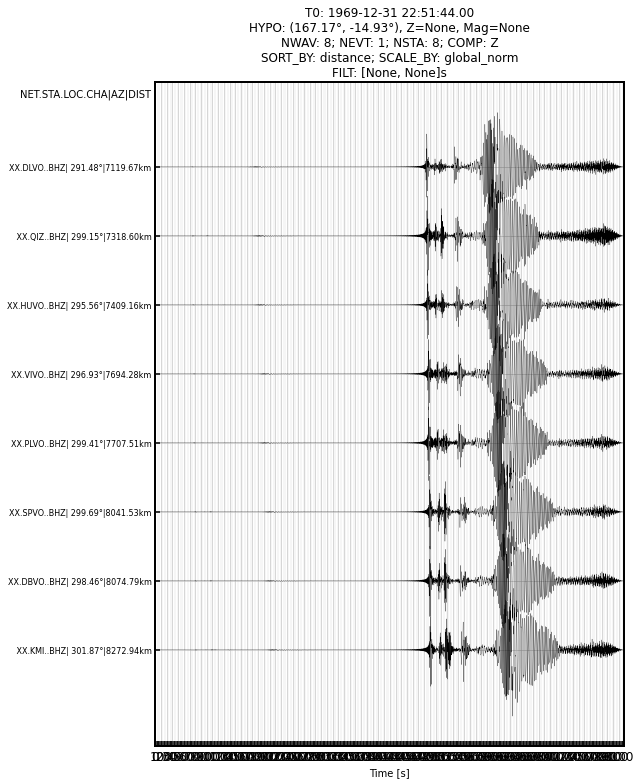

[2023-02-27 12:26:35] - pysep - INFO: finished record section in t=0:00:02.443915s


In [13]:
plotw_rs(st=st,overwrite=True,scale_by='global_norm',
            sort_by='distance',preprocess='st')